# Analyse E-commerce Product Reviews using NLP 

## **Import Packages**

In [ ]:
# !pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import tensorflow.keras as keras

In [2]:
# Import the generic libraries
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import csv

# Importing nltk libraries
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()


# Visualization libraries
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image # for world cloud image

# Spacy for preprocessing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

#Spell checker
!pip install pyspellchecker
from spellchecker import SpellChecker

# Modelling
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# xgboost
import xgboost as xgb

# Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam


# To change date to datetime
from datetime import datetime
import time
import re 

from collections import Counter
import string
import scipy.sparse

# Textblob
from textblob import TextBlob

# Gensim libraries
!pip install pyLDAvis
from gensim import corpora, models, similarities, matutils
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
from gensim.models import CoherenceModel


# To show all the columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

# to pickle dataframe
import pickle

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")


# Enable logging for gensim - optional but important
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from IPython.display import clear_output
clear_output()

## **Load the Dataset**

In [5]:
df = pd.read_csv("/content/GrammarandProductReviews.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
df.head(3)

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universalmusicgroupcashmoney/14331328,pinkfridayromanreloadedreupwdvd/000000000,pinkfridayromanreloadedreupwdvd/b009ntnhju,0602537205981",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,2018-02-04T07:28:12Z,"2018-01-15T04:45:00.000Z,2018-01-18T14:30:00.000Z,2017-12-20T12:28:00.000Z,2017-12-16T05:40:00.000Z,2017-12-07T09:27:00.000Z,2017-11-18T22:25:00.000Z",NaN,NaN,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/reviews/14331328?sort=helpfulness_desc&limit=200&offset=0,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,"lundbergorganiccinnamontoastricecakes/b000fvzw8y,lundbergorganiccinnamontoastricecakes/b005grcqwc,073416000391,lundbergorganiccinnamontoastricecakes/b0013jlzbu,0073416000391,lundbergorganiccinnamontoastricecakes/555222704,lundberg/00574764,lundbergorganiccinnamontoastricecakes/563800996",Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-23T02:53:06Z,2017-09-16T09:45:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,"lundbergorganiccinnamontoastricecakes/b000fvzw8y,lundbergorganiccinnamontoastricecakes/b005grcqwc,073416000391,lundbergorganiccinnamontoastricecakes/b0013jlzbu,0073416000391,lundbergorganiccinnamontoastricecakes/555222704,lundberg/00574764,lundbergorganiccinnamontoastricecakes/563800996",Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-06T04:49:31Z,2017-08-23T10:37:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391


# **Text Pre-processing**

In [8]:
print("Shape :", df.shape)

Shape : (71044, 25)


In [9]:
print("Columns :")
print(df.columns)

Columns :
Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc'],
      dtype='object')


### **Rename the Columns**

In [10]:
# Rename the column names
col_names = df.columns
new_col_names = [i.replace(".","_") for i in col_names]
df.columns = new_col_names

In [11]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews_date',
       'reviews_dateAdded', 'reviews_dateSeen', 'reviews_didPurchase',
       'reviews_doRecommend', 'reviews_id', 'reviews_numHelpful',
       'reviews_rating', 'reviews_sourceURLs', 'reviews_text', 'reviews_title',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'upc'],
      dtype='object')

In [12]:
print("Datatypes :\n",df.dtypes)

Datatypes :
 id                       object
brand                    object
categories               object
dateAdded                object
dateUpdated              object
ean                      object
keys                     object
manufacturer             object
manufacturerNumber       object
name                     object
reviews_date             object
reviews_dateAdded        object
reviews_dateSeen         object
reviews_didPurchase      object
reviews_doRecommend      object
reviews_id              float64
reviews_numHelpful      float64
reviews_rating            int64
reviews_sourceURLs       object
reviews_text             object
reviews_title            object
reviews_userCity         object
reviews_userProvince     object
reviews_username         object
upc                      object
dtype: object


In [13]:
print("Info :")
print(df.info())

Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  object 
 1   brand                 71044 non-null  object 
 2   categories            71044 non-null  object 
 3   dateAdded             71044 non-null  object 
 4   dateUpdated           71044 non-null  object 
 5   ean                   39065 non-null  object 
 6   keys                  71044 non-null  object 
 7   manufacturer          70903 non-null  object 
 8   manufacturerNumber    70841 non-null  object 
 9   name                  71044 non-null  object 
 10  reviews_date          70977 non-null  object 
 11  reviews_dateAdded     71044 non-null  object 
 12  reviews_dateSeen      71044 non-null  object 
 13  reviews_didPurchase   32158 non-null  object 
 14  reviews_doRecommend   60429 non-null  object 
 15  reviews_id  

In [14]:
print("Missing Value Count :")
print(df.isnull().sum())

Missing Value Count :
id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews_date               67
reviews_dateAdded           0
reviews_dateSeen            0
reviews_didPurchase     38886
reviews_doRecommend     10615
reviews_id              38886
reviews_numHelpful      38536
reviews_rating              0
reviews_sourceURLs          0
reviews_text               36
reviews_title             476
reviews_userCity        65634
reviews_userProvince    70595
reviews_username           96
upc                         2
dtype: int64


### **Percentage of missing values per column**

In [15]:
print("Percentage of missing values :")
print(df.isna().mean().round(4) * 100)

Percentage of missing values :
id                       0.00
brand                    0.00
categories               0.00
dateAdded                0.00
dateUpdated              0.00
ean                     45.01
keys                     0.00
manufacturer             0.20
manufacturerNumber       0.29
name                     0.00
reviews_date             0.09
reviews_dateAdded        0.00
reviews_dateSeen         0.00
reviews_didPurchase     54.74
reviews_doRecommend     14.94
reviews_id              54.74
reviews_numHelpful      54.24
reviews_rating           0.00
reviews_sourceURLs       0.00
reviews_text             0.05
reviews_title            0.67
reviews_userCity        92.39
reviews_userProvince    99.37
reviews_username         0.14
upc                      0.00
dtype: float64


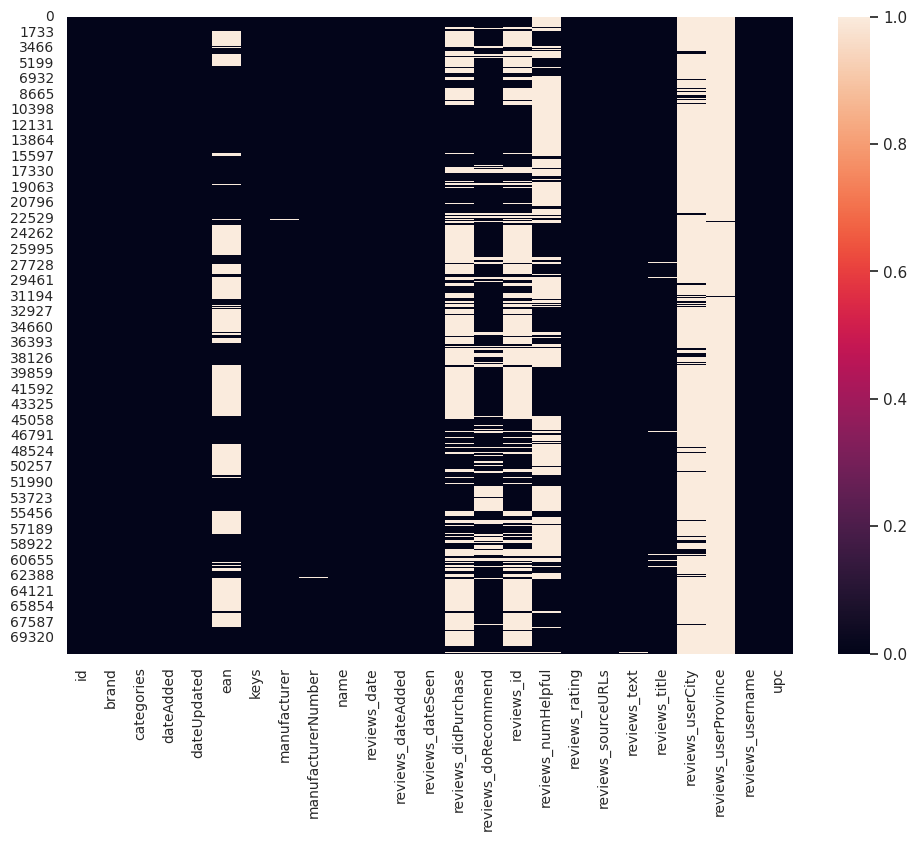

In [16]:
#Visualization of Missing Values

# Plot it
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(data=df.isnull())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()



In [17]:
print("Total Missing Value Count : ", df.isnull().sum().values.sum())

Total Missing Value Count :  296152


In [18]:
# Drop the columns with less than 20% of values
missing_val_threshold = len(df) * .2
df.dropna(thresh = missing_val_threshold, axis = 1, inplace = True)

In [19]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews_date',
       'reviews_dateAdded', 'reviews_dateSeen', 'reviews_didPurchase',
       'reviews_doRecommend', 'reviews_id', 'reviews_numHelpful',
       'reviews_rating', 'reviews_sourceURLs', 'reviews_text', 'reviews_title',
       'reviews_username', 'upc'],
      dtype='object')

In [20]:
# Shape of Dataset
df.shape

(71044, 23)

In [21]:
# Drop the rows where "reviews.text" or "reviews.date" feature has Null values
df.dropna(subset=['reviews_text','reviews_date'], inplace=True)

In [22]:
# Shape of Dataset
df.shape

(70941, 23)

In [23]:
print("Percentage of missing values :")
print(df.isna().mean().round(4) * 100)

Percentage of missing values :
id                      0.00
brand                   0.00
categories              0.00
dateAdded               0.00
dateUpdated             0.00
ean                    45.07
keys                    0.00
manufacturer            0.20
manufacturerNumber      0.28
name                    0.00
reviews_date            0.00
reviews_dateAdded       0.00
reviews_dateSeen        0.00
reviews_didPurchase    54.67
reviews_doRecommend    14.82
reviews_id             54.67
reviews_numHelpful     54.18
reviews_rating          0.00
reviews_sourceURLs      0.00
reviews_text            0.00
reviews_title           0.65
reviews_username        0.13
upc                     0.00
dtype: float64


### **Combine Review Text and Title into one**

In [24]:
# Joining Review Text and Title 
df['Review'] = df['reviews_title'].map(str) + " " + df['reviews_text'] 

### **Lowercasing**

In [25]:
# Lowercasing the reviews and title column
df['Review'] = df['Review'].apply(lambda x : x.lower())

In [26]:
df['Review'][0]

"just awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

### **Remove Punctuation**

In [27]:
# Remove punctuation 
df['Review'] = df['Review'].str.replace('[^\w\s]','')

In [28]:
df['Review'][0]

'just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy'

### **Remove Stopwords**

In [29]:
# Remove Stopwords
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [30]:
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphors crazy'

### **Lemmatization**

In [31]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [32]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [33]:
df['Review']=df['Review'].apply(lambda x: lemmatize_sentence(x))

In [34]:
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphor crazy'

### **Spelling Correction**

In [ ]:
spell = SpellChecker()

df['Review']=df['Review'].apply(lambda x: ' '.join(spell.correction(word) for word in nltk.word_tokenize(x)))

In [ ]:
# df.to_csv("/content/drive/My Drive/Updated_GrammarandProductReviews.csv")

### **Normalization**
https://sentic.net/microtext-normalization.pdf

### **Standarization**

### **Noise Removal**

In [36]:
def scrub_words(text):
    """Basic cleaning of texts."""
    
    # remove html markup
    text=re.sub("(<.*?>)","",text)
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text=text.strip()
    return text

In [37]:
df['Review']=df['Review'].apply(lambda x: scrub_words(x))

In [38]:
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give  star rating way metaphor crazy'

### **Word Count**

In [39]:
df['Review_WC'] = df['Review'].apply(lambda x: len(str(x).split(" ")))
df[['Review_WC','Review']].head(3)

,Review_WC,Review
0,21,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,7,good good flavor review collect part promotion
2,3,good good flavor


<Axes: xlabel='Review_WC', ylabel='Density'>

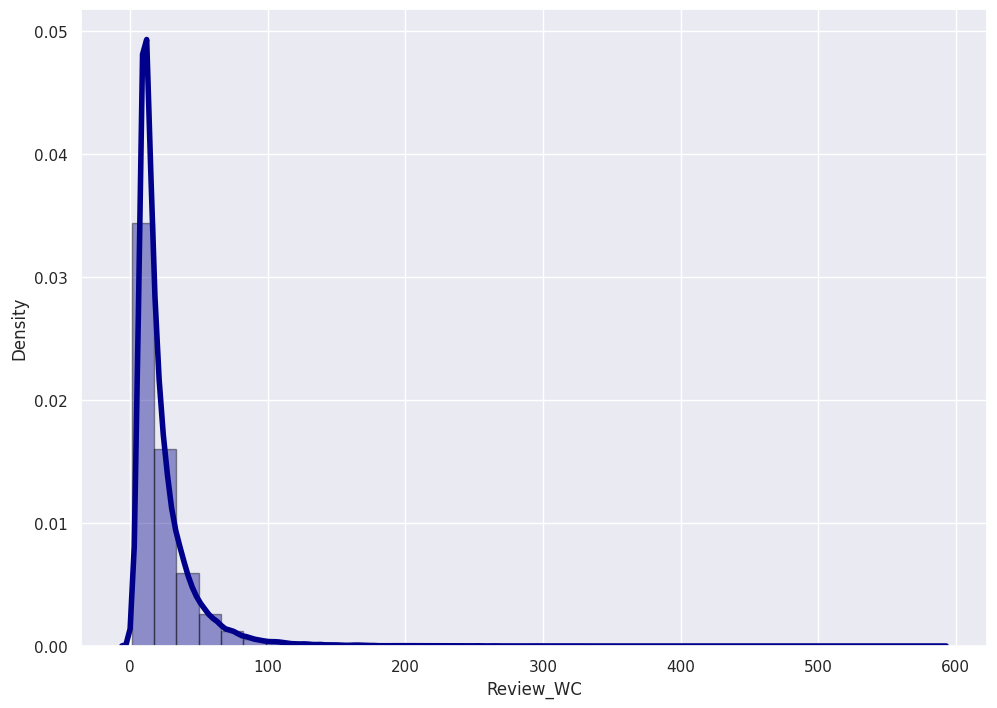

In [40]:
# Density Plot and Histogram of all Word Count
sns.distplot(df['Review_WC'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### **Character Count**

In [41]:
df['Review_CC'] = df['Review'].str.len() ## this also includes spaces
df[['Review_CC','Review']].head(3)

,Review_CC,Review
0,116,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,46,good good flavor review collect part promotion
2,16,good good flavor


<Axes: xlabel='Review_CC', ylabel='Density'>

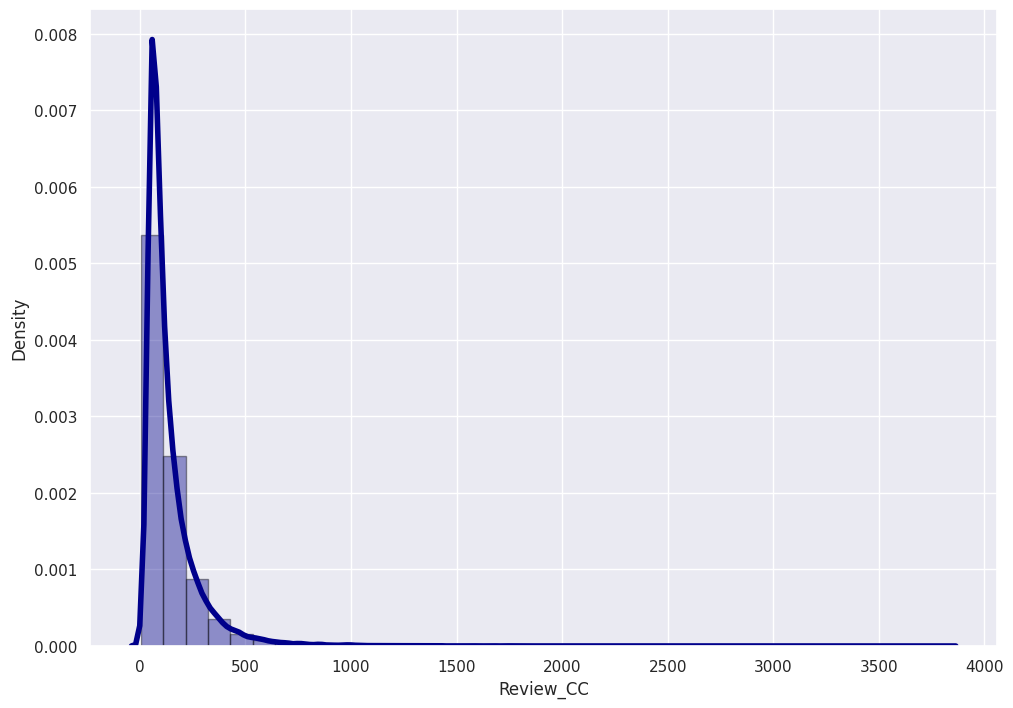

In [42]:
# Density Plot and Histogram of all Character Count
sns.distplot(df['Review_CC'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### **Average Word Length**

In [43]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df['Review_AWL'] = df["Review"].apply(lambda x: avg_word(x))
df[['Review_AWL','Review']].head(3)

,Review_AWL,Review
0,4.800000,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,5.714286,good good flavor review collect part promotion
2,4.666667,good good flavor


<Axes: xlabel='Review_AWL', ylabel='Density'>

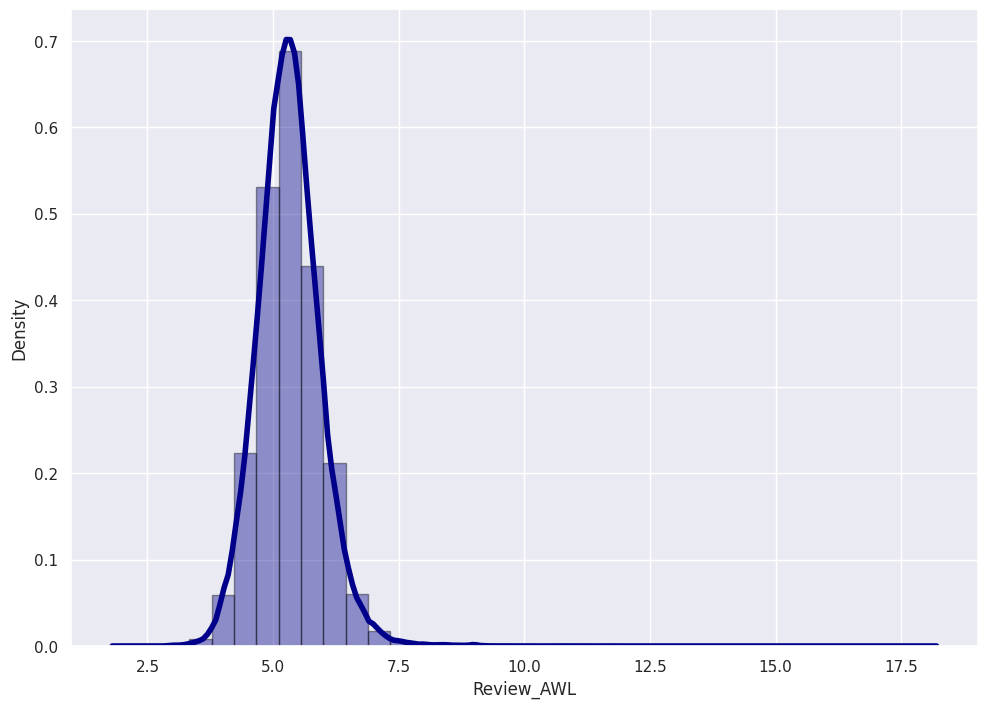

In [44]:
# Density Plot and Histogram of Average Word Length
sns.distplot(df['Review_AWL'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### **Top 30 Common Words**

In [45]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,10))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

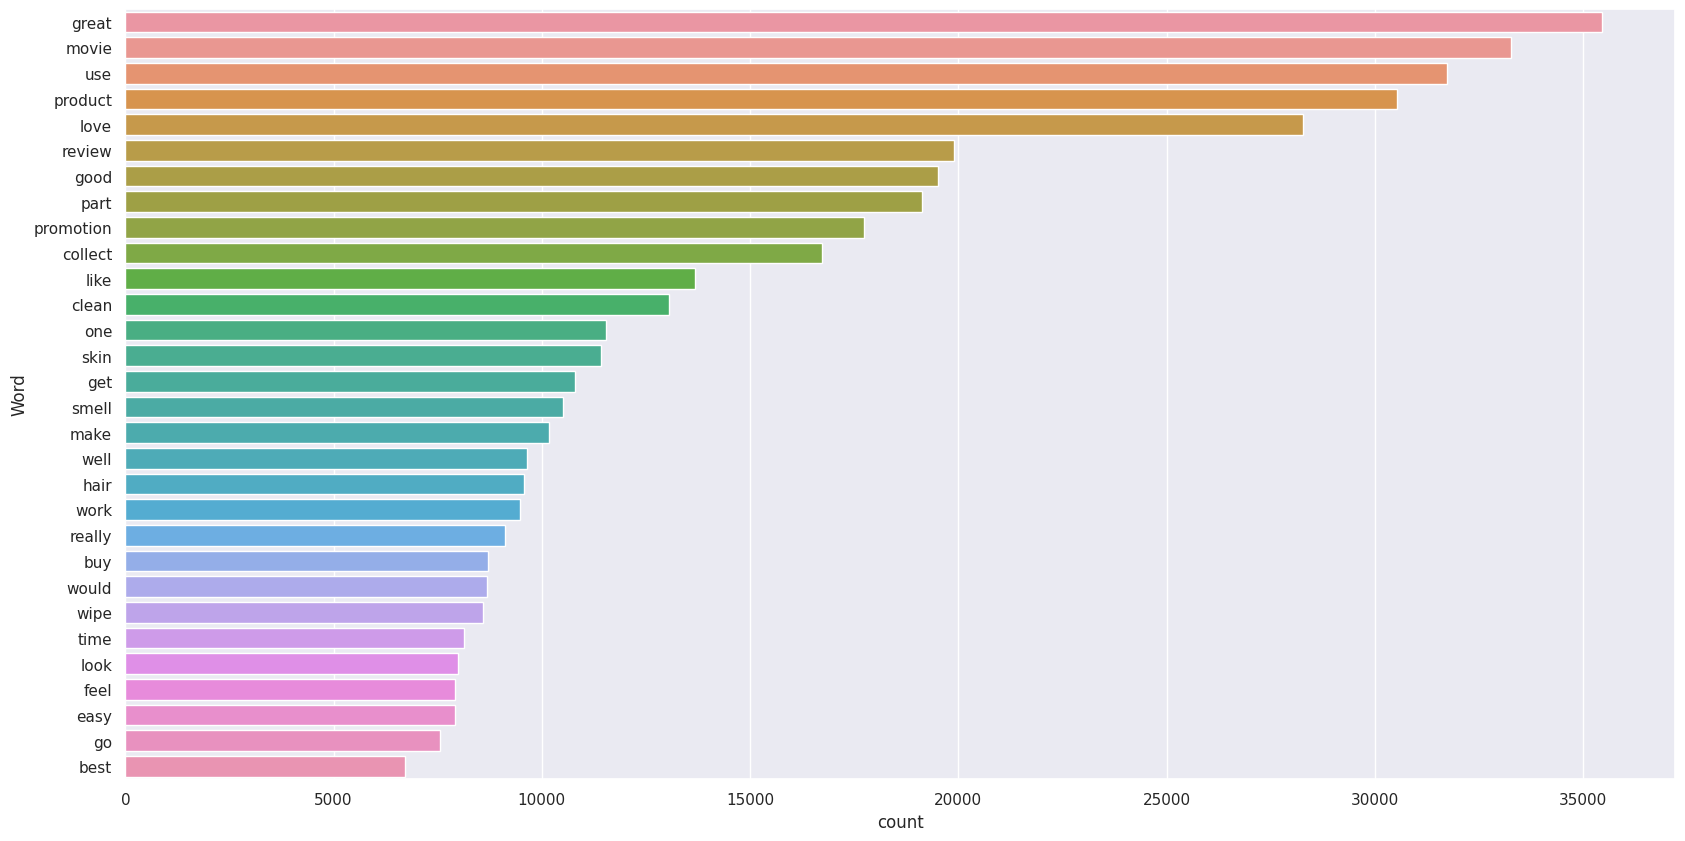

In [46]:
freq_words(df['Review'])

### **Top 30 Rare Words**

In [47]:
# function to plot least frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nsmallest(columns="count", n = terms) 
  plt.figure(figsize=(20,10))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

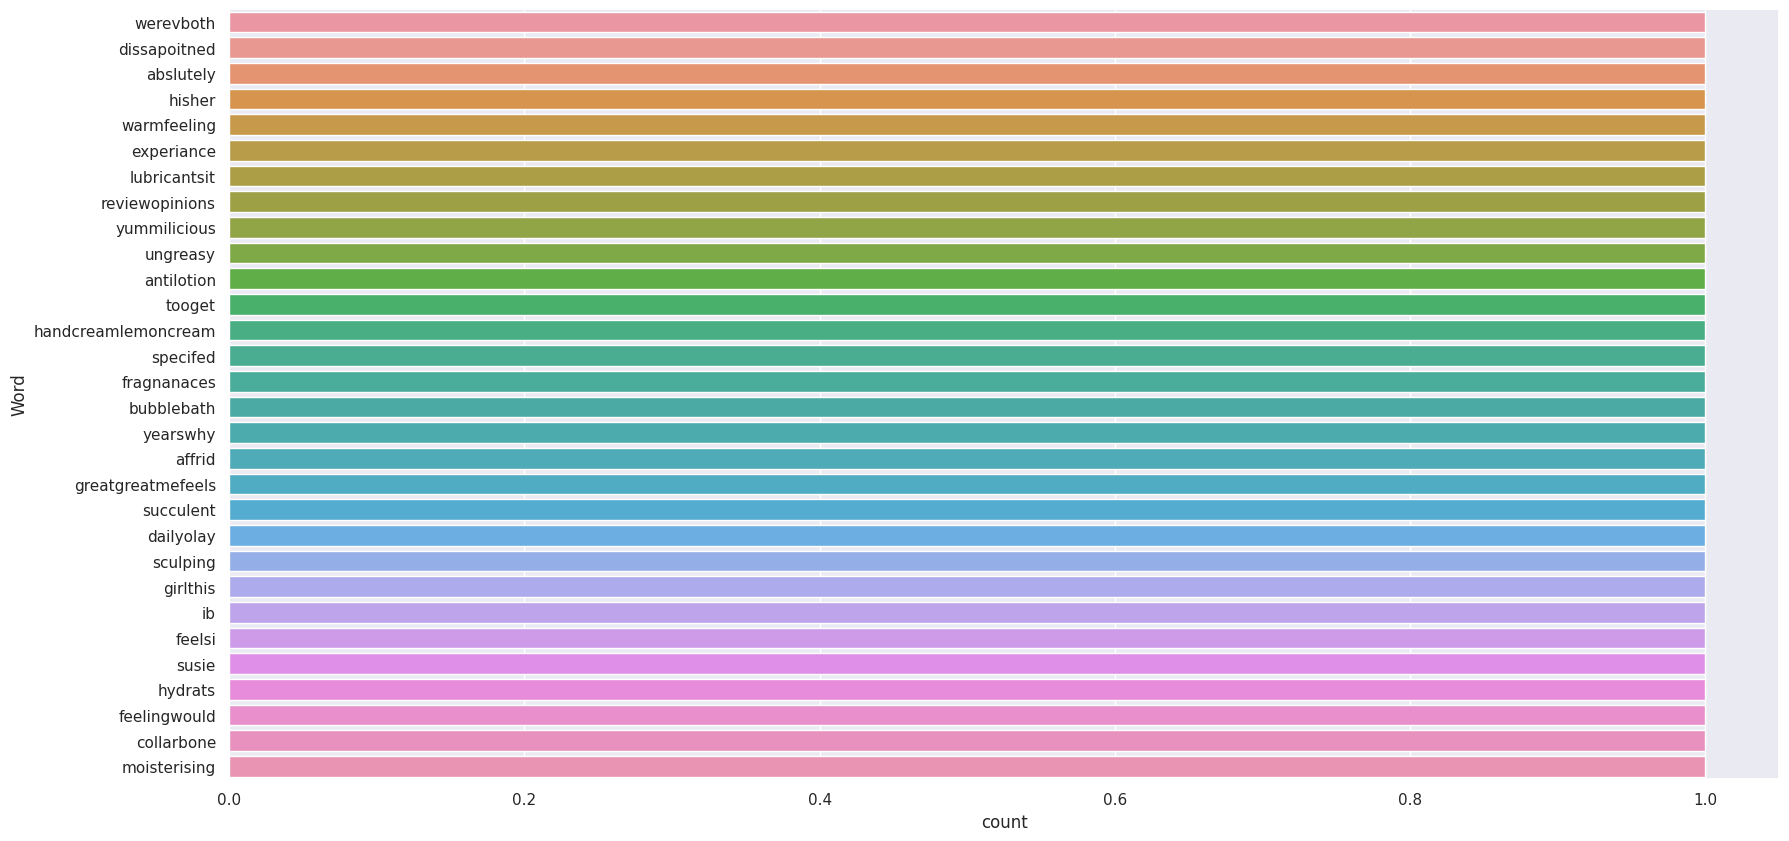

In [48]:
freq_words(df['Review'])

### **Term Frequency**

In [49]:
df_tf = (df['Review'][0:1]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
df_tf.columns = ['words','tf']
df_tf

,words,tf
0,awesome,1
1,listen,1
2,metaphor,1
3,way,1
4,rating,1
5,star,1
6,,1
7,give,1
8,gym,1
9,everyday,1


### **IDF**

In [50]:
for i,word in enumerate(df_tf['words']):
  df_tf.loc[i, 'idf'] = np.log(df_tf.shape[0]/(len(df[df['Review'].str.contains(word)])))


In [51]:
df_tf

,words,tf,idf
0,awesome,1,-5.115996
1,listen,1,-2.488867
2,metaphor,1,1.945910
3,way,1,-5.925147
4,rating,1,-2.358155
5,star,1,-5.010953
6,,1,-8.125081
7,give,1,-4.897840
8,gym,1,-1.349927
9,everyday,1,-3.678107


### **TF-IDF**

In [52]:
df_tf['tfidf'] = df_tf['tf'] * df_tf['idf']
df_tf

,words,tf,idf,tfidf
0,awesome,1,-5.115996,-5.115996
1,listen,1,-2.488867,-2.488867
2,metaphor,1,1.945910,1.945910
3,way,1,-5.925147,-5.925147
4,rating,1,-2.358155,-2.358155
5,star,1,-5.010953,-5.010953
6,,1,-8.125081,-8.125081
7,give,1,-4.897840,-4.897840
8,gym,1,-1.349927,-1.349927
9,everyday,1,-3.678107,-3.678107


### **Transforming Reviews Date to Python DateTime Format**

In [53]:
# Convert the Rating Date column in datetime format
df['reviews_date'] = df['reviews_date'].str.replace(".000Z","")
df['reviews_date'] = df['reviews_date'].str.replace("Z","")

In [54]:
date = []
for i,j in enumerate(df['reviews_date']): 
  try :
    date.append(datetime.strptime(j, "%Y-%m-%dT%H:%M:%S"))
  except:
    print(i)
    j = df['reviews_date'][0]
    date.append(datetime.strptime(j, "%Y-%m-%dT%H:%M:%S"))

  
df['reviews_date'] = date

28687
28688
28689
28690
28691
28692
28693
28694


# **Exploratory Data Analysis**

### **Unique Values**

In [55]:
for i in ['brand', 'categories','manufacturer','name','reviews_id','reviews_rating']:
  print("No. of unique values in %s is : %s" %(i, df[i].nunique()))

No. of unique values in brand is : 387
No. of unique values in categories is : 575
No. of unique values in manufacturer is : 458
No. of unique values in name is : 594
No. of unique values in reviews_id is : 31372
No. of unique values in reviews_rating is : 5


### **Distribution of top 25 reviewed brands**

In [56]:
df['brand'] = df['brand'].replace("L'oreal Paris","L'Oreal Paris")
df['brand'] = df['brand'].replace("Sony","Sony Pictures")

In [59]:
!pip install matplotlib
import importlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df['brand'].value_counts()[0:25].sort_values().plot(kind = 'barh')

### **Distribution of reviewed categories**

In [62]:
df["product_cat"] = df["categories"].apply(lambda x: x.split(",")[0])

df['product_cat'] = df['product_cat'].replace("Movies","Movies & TV Shows")
df['product_cat'] = df['product_cat'].replace("Food","Food & Beverage")
df['product_cat'] = df['product_cat'].replace("Household Chemicals","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Music on CD or Vinyl","Musical Instruments & Karaoke")
df['product_cat'] = df['product_cat'].replace("Pro Audio","Musical Instruments & Karaoke")
df['product_cat'] = df['product_cat'].replace("Baby","Kids")
df['product_cat'] = df['product_cat'].replace("Kids' Rooms","Kids")
df['product_cat'] = df['product_cat'].replace("Brand Shop","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Featured Brands","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Home Improvement","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Furniture","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Video Games","Sports & Outdoors")
df['product_cat'] = df['product_cat'].replace("Home","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Mobile","Electronics")
df['product_cat'] = df['product_cat'].replace("Photography","Electronics")
df['product_cat'] = df['product_cat'].replace("Patio & Garden","Accessories")
df['product_cat'] = df['product_cat'].replace("Gift Finder","Accessories")
df['product_cat'] = df['product_cat'].replace("Auto & Tires","Accessories")
df['product_cat'] = df['product_cat'].replace("Kitchen & Dining","Food & Beverage")


In [ ]:
df['product_cat'].value_counts()[0:25].sort_values().plot(kind = 'barh')

### **Distribution of top 25 reviewed manufactures**

In [ ]:
df['manufacturer'] = df['manufacturer'].replace("L'oreal Paris","L'Oreal Paris")
df['manufacturer'] = df['manufacturer'].replace("SONY CORP","Sony Pictures")
df['manufacturer'].value_counts()[0:25].sort_values().plot(kind = 'barh')

### **Distribution of Review Ratings**

<Axes: ylabel='count'>

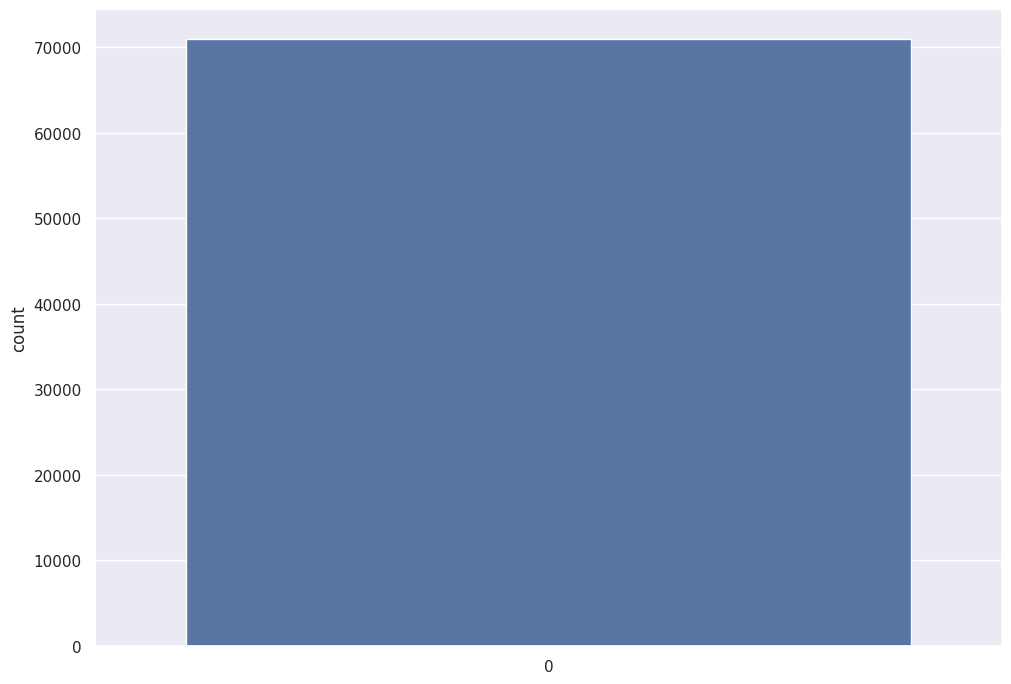

In [64]:
# Density Plot and Histogram of Reviews Ratings
sns.countplot(df['reviews_rating'])

### **Year Wise Ratings**

In [65]:
df['year'], df['day'], df['month'] = df['reviews_date'].dt.year, df['reviews_date'].dt.day, df['reviews_date'].dt.month

In [66]:
df['hour'], df['minute'], df['second'] = df['reviews_date'].dt.hour, df['reviews_date'].dt.minute, df['reviews_date'].dt.second

<Axes: xlabel='count', ylabel='year'>

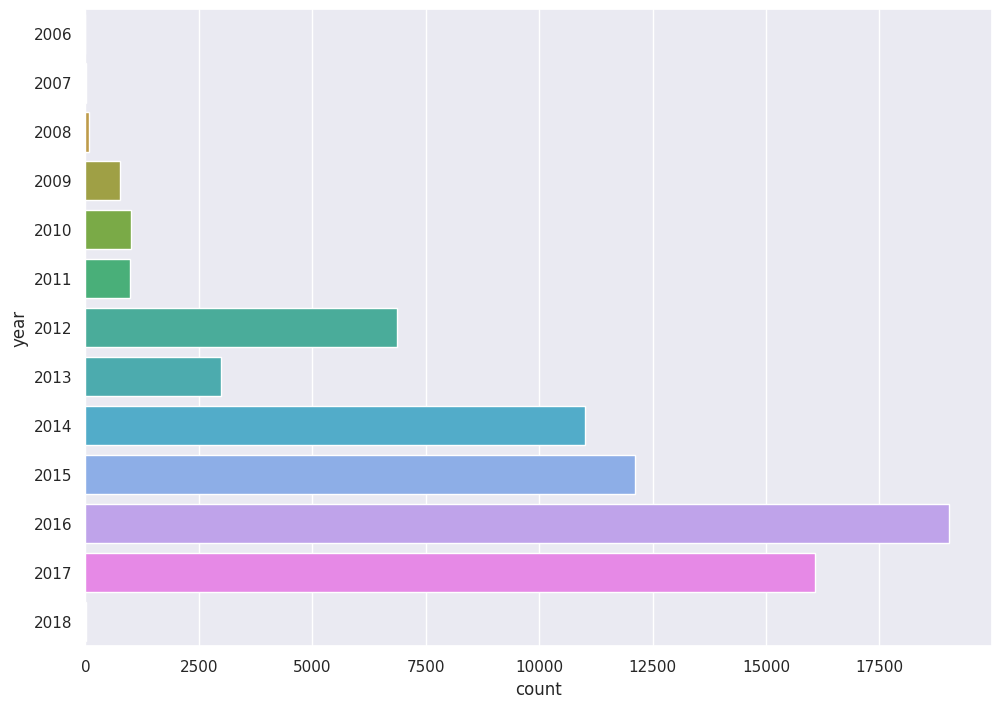

In [67]:
sns.countplot(y=df['year'])

<Axes: xlabel='count', ylabel='year'>

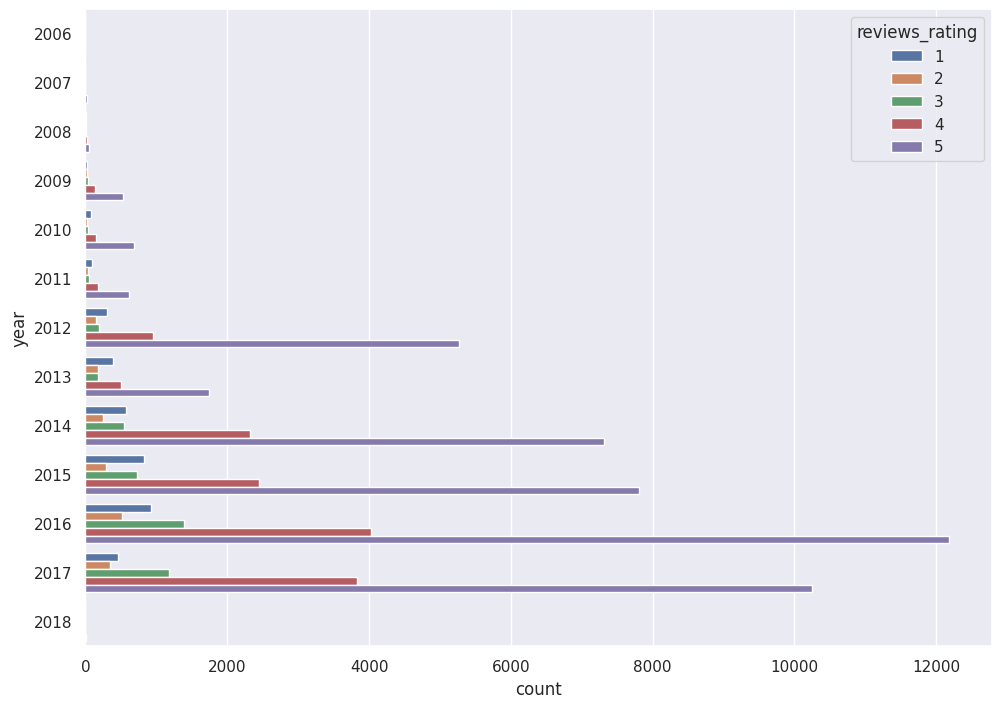

In [68]:
sns.countplot(y=df['year'], hue=df['reviews_rating'])

### **Hour Wise Ratings**

<Axes: xlabel='count', ylabel='hour'>

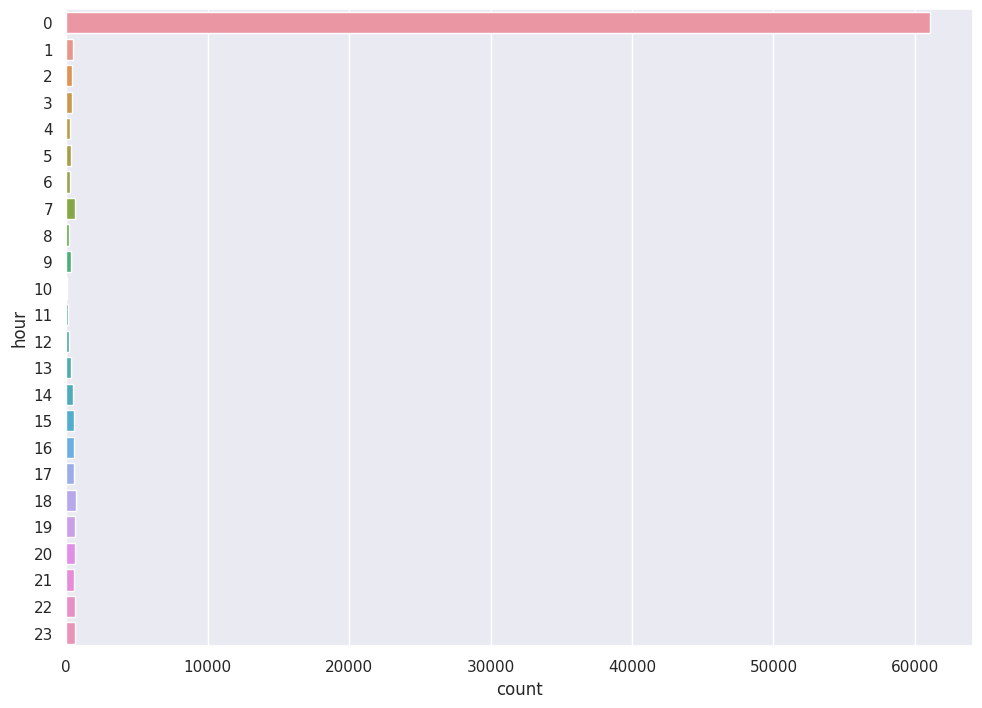

In [69]:
sns.countplot(y=df['hour'])

<Axes: xlabel='count', ylabel='hour'>

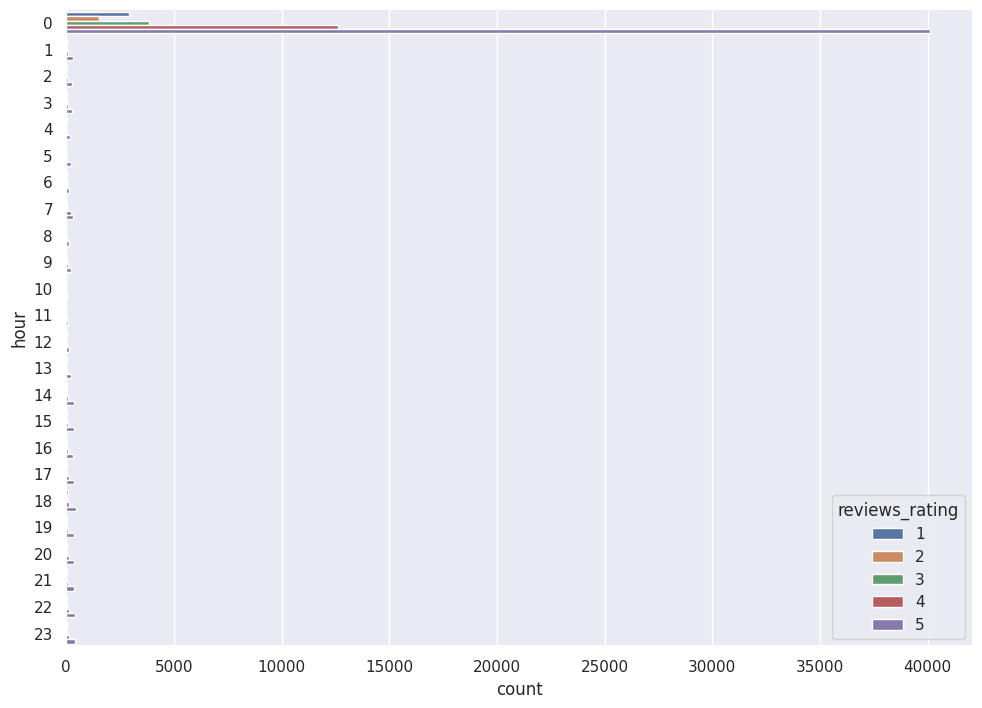

In [70]:
sns.countplot(y=df['hour'], hue=df['reviews_rating'])

### **Category vs Ratings**

In [71]:
df['product_cat'].nunique()

18

<Axes: xlabel='count', ylabel='product_cat'>

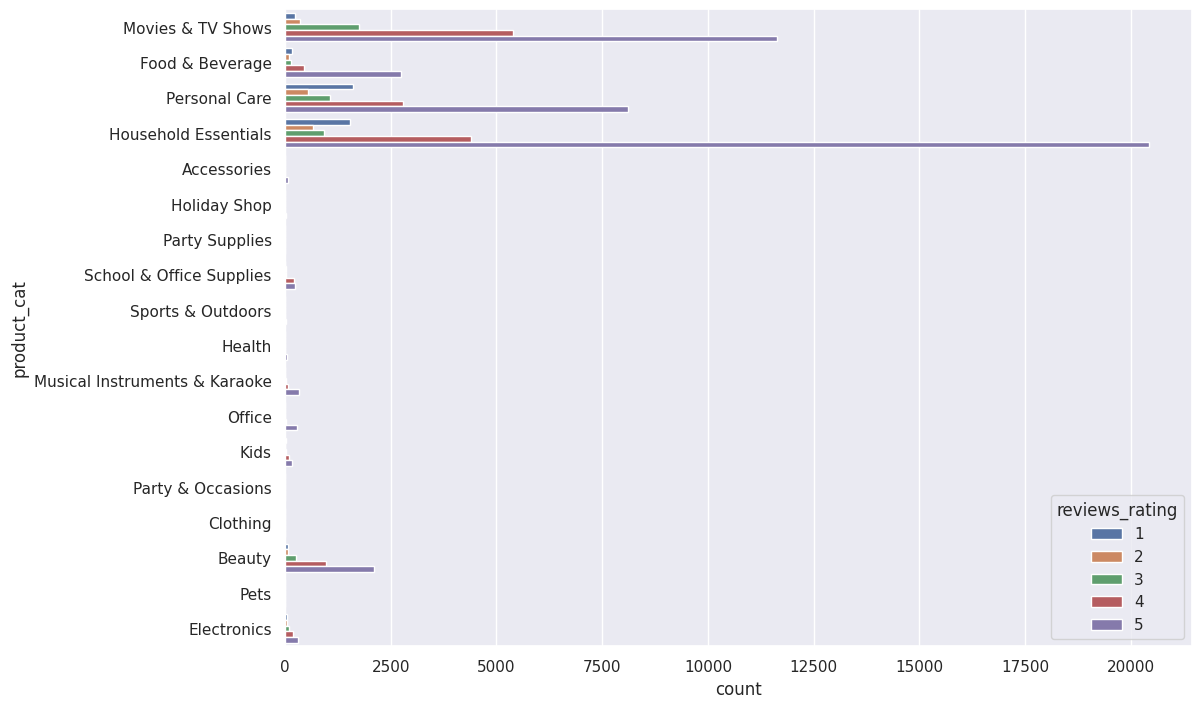

In [72]:
sns.countplot(y=df['product_cat'], hue=df['reviews_rating'])

<Axes: xlabel='count', ylabel='reviews_rating'>

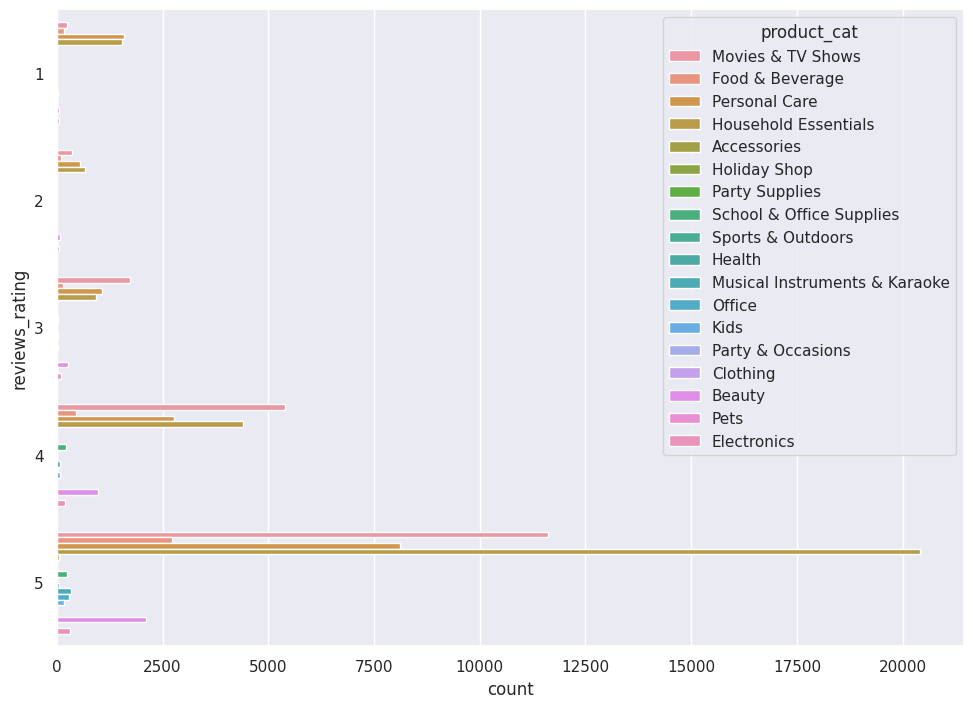

In [73]:
sns.countplot(y=df['reviews_rating'], hue=df['product_cat'])

### **Brands vs Ratings**

<Axes: xlabel='count', ylabel='brand'>

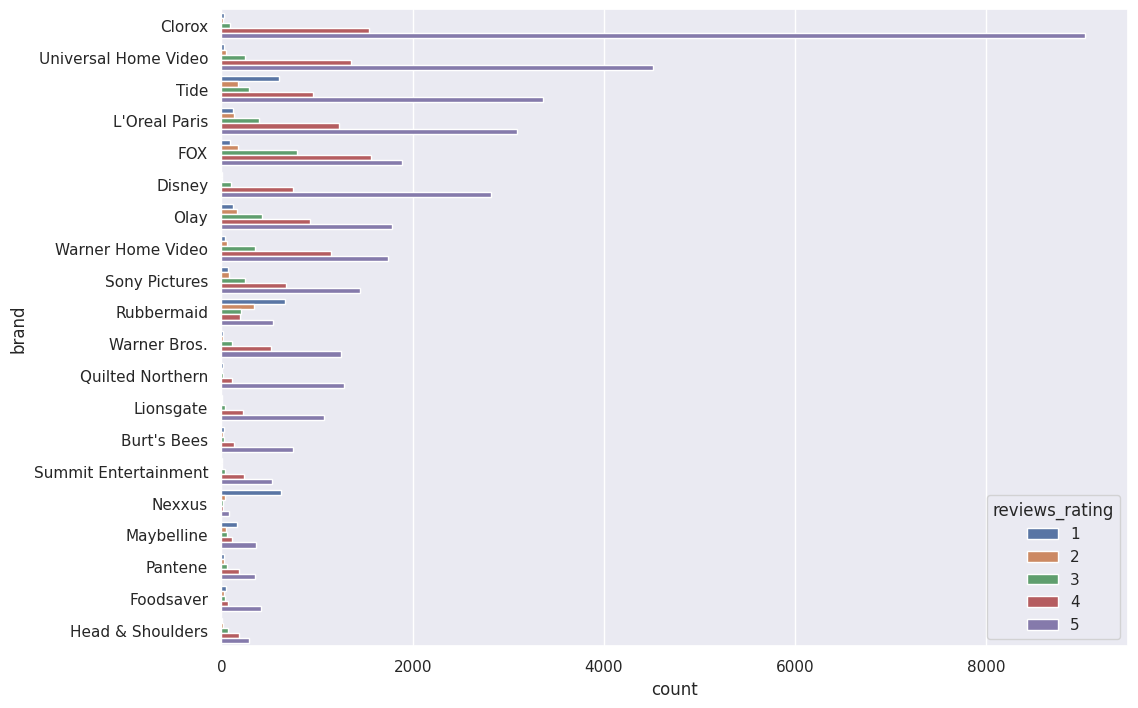

In [74]:
sns.countplot(y=df['brand'], hue=df['reviews_rating'], order=df['brand'].value_counts().iloc[:20].index)

### **Word Clouds**

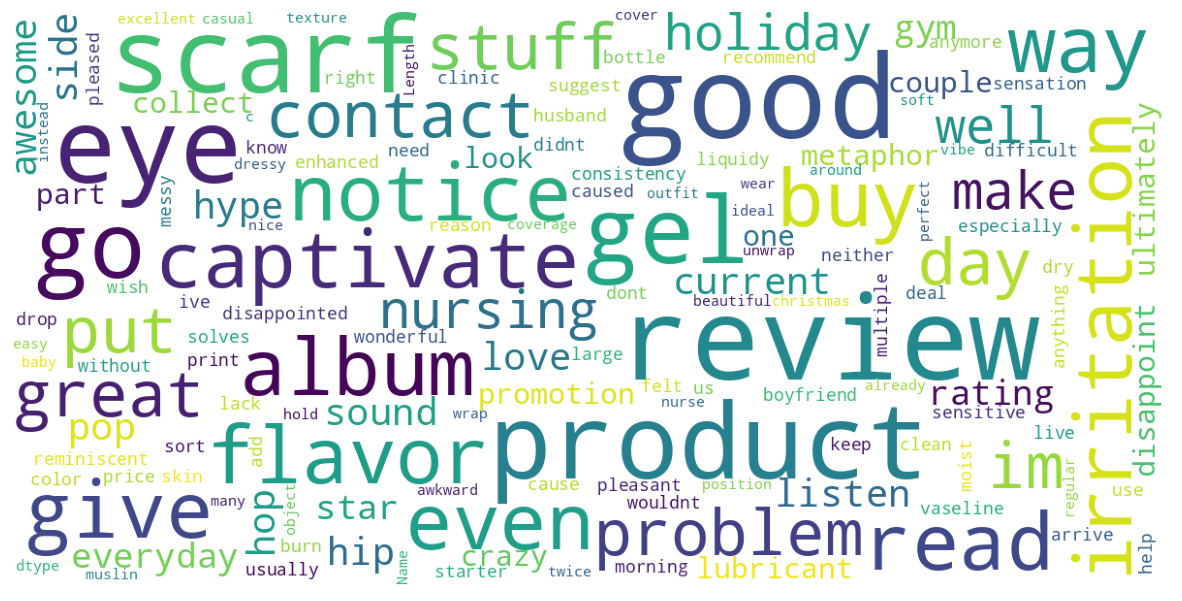

In [75]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['Review'])

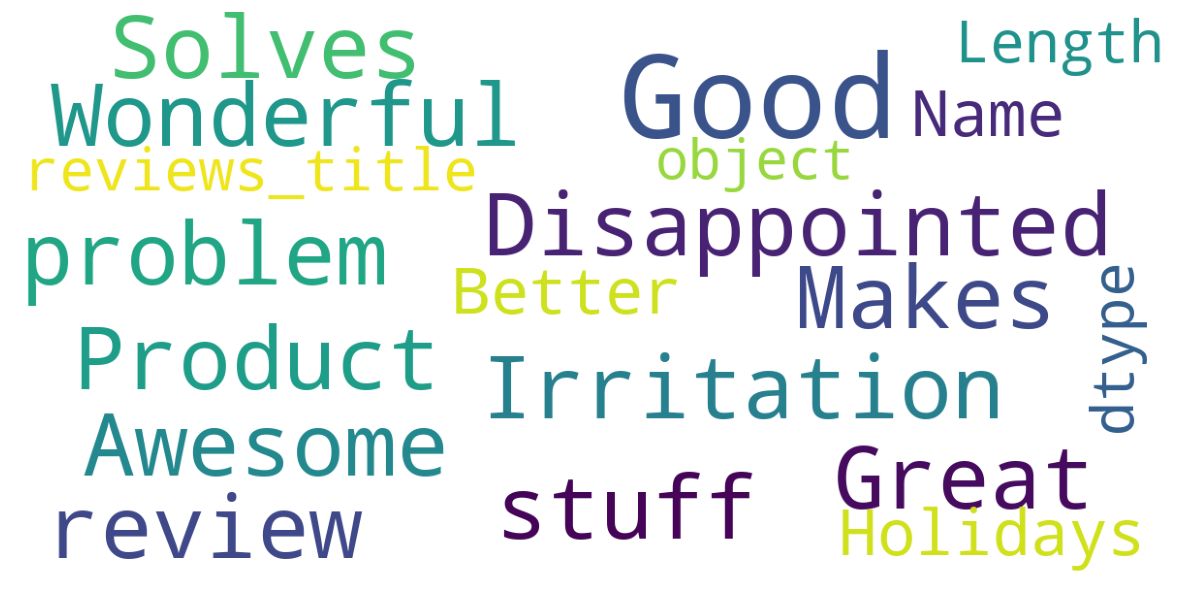

In [76]:
show_wordcloud(df['reviews_title'])
# Great = 10938, great = 3133
# Disappointed = 156, disappointed = 75, Disappointing = 50, disappointing = 25, dissapoitned = 

In [77]:
# len(big_list)  # reviews_title

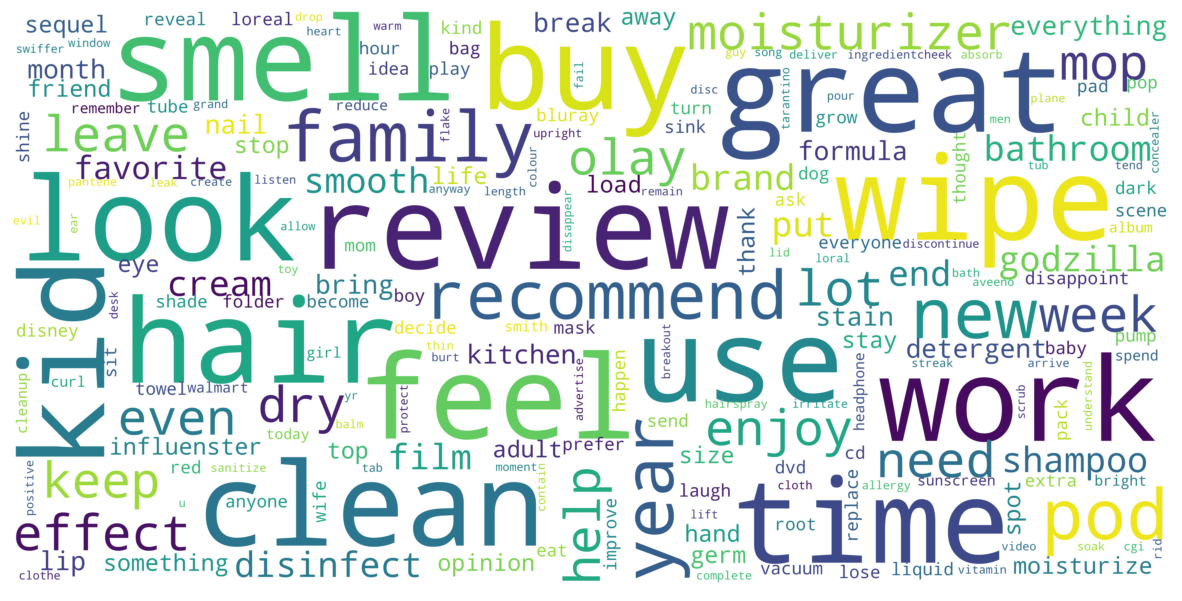

In [78]:
# try to tokenize to individual word (uni-gram) - reviews.text

split_title = []
listCounts = []
split_title = [x.split(" ") for x in df['Review'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [79]:
len(big_list)   # reviews_text


1618198

### **Genuine Reviews**

In [80]:
# on the reviews.didPurchase column, replace 38,886 null fields with "Null"
df['reviews_didPurchase'].fillna('Null', inplace=True)


In [ ]:
plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Number of Genuine Reviews', fontsize=17)
ax.tick_params(labelsize=13)

In [82]:
df['reviews_didPurchase'].value_counts()


Null     38785
False    28474
True      3682
Name: reviews_didPurchase, dtype: int64

In [83]:
# shoppers who did purchased the product and provided the review = 5%
print("Percentage of genuine reviews :",368200/(38785 + 28474))

Percentage of genuine reviews : 5.474360308657578


### **Correlation Map**

<Axes: >

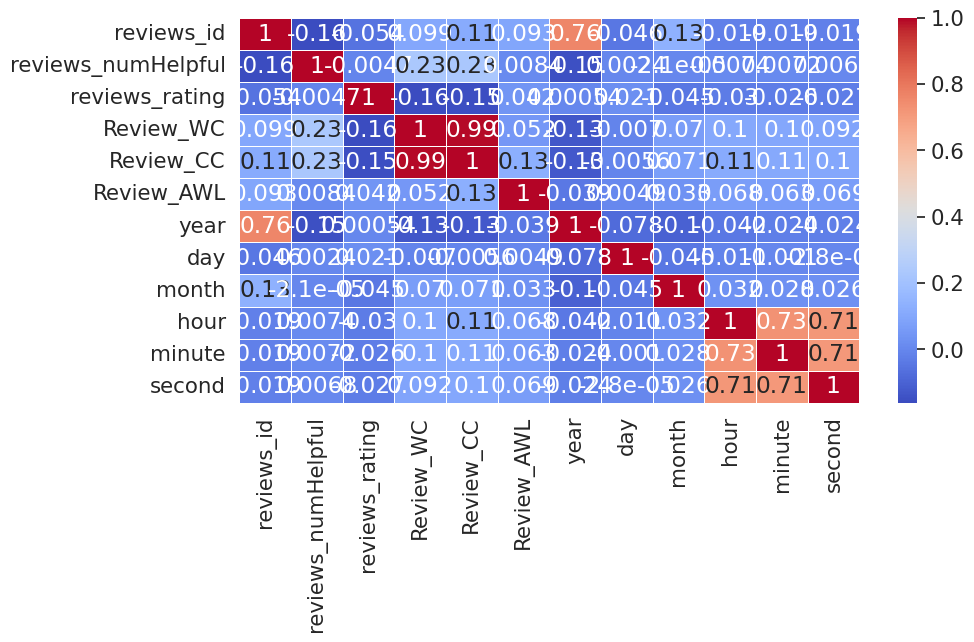

In [84]:
# not much info in the correlation map
sns.set(font_scale=1.4)
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True,linewidths=.5)

### **Most Bought Product**

In [85]:
# "The Foodsaver174 10 Cup Fresh Container - Fac10-000" is purchased almost 500 times
df_genuine = df[df['reviews_didPurchase'] == True]
df_genuine['name'].value_counts()

The Foodsaver174 10 Cup Fresh Container - Fac10-000                      477
Pantene Airspray Hairspray - 7 Oz                                        443
Hormel Chili, No Beans                                                    91
Coty Airspun Face Powder, Translucent Extra Coverage                      88
Just For Men Brush-In Color Gel For Mustache & Beard, Dark Brown M-45     80
                                                                        ... 
Kenroy Home Table Lamp - Teal                                              1
Tai Pei Sweet & Sour Chicken                                               1
Lucy's Sugar Cookies, 5.5oz                                                1
Black Radiance Artisan Color Baked Blush, Warm Berry                       1
If A Man Answers (dvd)                                                     1
Name: name, Length: 304, dtype: int64

In [ ]:
df_genuine['name'].value_counts()[0:10].plot(kind ='barh', figsize=[10,6], fontsize=20).invert_yaxis()

### **Most purchased Product - 5 Rating**

In [87]:
df_mbp = df_genuine[df_genuine['name'] == 'The Foodsaver174 10 Cup Fresh Container - Fac10-000']
df_mbp = df_mbp[df_mbp['reviews_rating']==5]
# keep relevant columns only
df_mbp = df_mbp[[ 'reviews_rating', 'Review']]
df_mbp.head(3)

,reviews_rating,Review
46943,5,clear view content love fact see inside easy fill vacuum stack nicely take less space
46944,5,perfect size use foodsaver container overi love add longevity freshness leftover
46945,5,stay seal needed bought set well cup container use fruit lettucethey seal easily stay seal needed big improvement old container


### **Most purchased Product - 1 Rating**

In [88]:
# filter most purchased product with 1 star rating
df_lvp = df_genuine[df_genuine['name'] == 'The Foodsaver174 10 Cup Fresh Container - Fac10-000']
df_lvp = df_lvp[df_lvp['reviews_rating']==1]
# keep relevant columns only
df_lvp = df_lvp[[ 'reviews_rating', 'Review']]
df_lvp.head(3)

,reviews_rating,Review
46762,1,unable use think ready use know need buy part make work
46763,1,happy buy month ago try vacuum seal seal stay day need reseal vacuum seal never stay
46765,1,unhappy can not make head tail use product sell part need


# **Training Data Preparation**

### **Defining features and target variables**

In [89]:
x=df['Review']
y=df['reviews_rating']


### **Using the n-gram tfidf vectorizer**

In [90]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3) )  

word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

In [91]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)

char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

train_features = hstack([train_char_features, train_word_features])

### **Splitting the dataset into train and test**

In [92]:
seed = 50 

X_train, X_test, y_train, y_test = train_test_split(train_features, y, test_size=0.3, random_state=seed)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (49658, 1307941)
y_train (49658,)
X_test (21283, 1307941)
y_test (21283,)


# **ML Model**

### **Random Forest Classifier**

In [ ]:
time1 = time.time()

classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=seed, n_jobs=-1)
classifier.fit(X_train,y_train)

preds1 = classifier.predict(X_test)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

In [ ]:
print("Random Forest Model accuracy", accuracy_score(preds1, y_test))
print(classification_report(preds1, y_test))
print(confusion_matrix(preds1, y_test))

Random Forest Model accuracy 0.7251327350467509
              precision    recall  f1-score   support

           1       0.54      0.84      0.66       662
           2       0.17      1.00      0.29        95
           3       0.13      0.89      0.23       196
           4       0.17      0.72      0.27      1027
           5       0.99      0.72      0.83     19303

    accuracy                           0.73     21283
   macro avg       0.40      0.84      0.46     21283
weighted avg       0.93      0.73      0.79     21283

[[  559    60    28    11     4]
 [    0    95     0     0     0]
 [    0     3   175    15     3]
 [    4    20   147   741   115]
 [  477   381   955  3627 13863]]


### **Logistic Regression**

In [95]:
time1 = time.time()

logit = LogisticRegression(C=1, multi_class='ovr')
logit.fit(X_train,y_train)
preds3 = logit.predict(X_test)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 378.05 seconds


In [96]:
print("Logistic Regression accuracy", accuracy_score(preds3, y_test))
print(classification_report(preds3, y_test))
print(confusion_matrix(preds3, y_test))

Logistic Regression accuracy 0.7362683832166518
              precision    recall  f1-score   support

           1       0.69      0.72      0.71       998
           2       0.05      0.71      0.10        41
           3       0.22      0.60      0.32       467
           4       0.28      0.53      0.37      2329
           5       0.96      0.77      0.85     17448

    accuracy                           0.74     21283
   macro avg       0.44      0.67      0.47     21283
weighted avg       0.85      0.74      0.78     21283

[[  720   149    72    30    27]
 [    5    29     7     0     0]
 [   24    64   282    73    24]
 [   43    92   415  1242   537]
 [  248   225   529  3049 13397]]


# **Deep Learning Model**

### **Label the Ratings** 



In [97]:
# To classify ratings<4 as sentiment, i.e. replace ratings less than 4 as not happy
# label 1= Happy
# label 2= Unhappy

df['sentiment'] = df['reviews_rating']<4
train_text, test_text, train_y, test_y = train_test_split(df['Review'],df['sentiment'],test_size = 0.2)

In [98]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28435 unique tokens.


In [99]:
MAX_SEQUENCE_LENGTH = 200
#pad sequences are used to bring all sentences to same size.
# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (56752, 200)
Shape of data test tensor: (14189, 200)


In [100]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,input_shape=(1,)))
model.add(Dense(1, activation='sigmoid'))


In [101]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

[Optimizers](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6)

In [102]:
model.fit(x_train, train_y,
          batch_size=128,
          epochs=1,
          validation_data=(x_test, test_y))

444/444 [==============================] - 1051s 2s/step - loss: 0.2430 - accuracy: 0.9081 - val_loss: 0.2034 - val_accuracy: 0.9259
